In [1]:
###############################################
# 1) IMPORT LIBRARIES & SET PATHS
###############################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B"

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Using dataset at:", PREPROCESS_ROOT)
print("Saving models to:", CHECKPOINT_DIR)


Using dataset at: /kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B
Saving models to: /kaggle/working/checkpoints


In [2]:
###############################################
# 2) DATASET CLASS
###############################################
class PTDataset(Dataset):
    def __init__(self, imgs, gts):
        self.imgs = imgs
        self.gts = gts

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.load(self.imgs[idx]).float()
        gt  = torch.load(self.gts[idx]).float()

        if img.ndim == 2: img = img.unsqueeze(0)
        if gt.ndim == 2:  gt = gt.unsqueeze(0)

        return img, gt


In [3]:
###############################################
# 3) LOAD TRAIN / VAL DATA  + VERIFY COUNTS
###############################################
from pathlib import Path

# Correct TrainB paths
train_img_dir = f"{PREPROCESS_ROOT}/TrainB/images"
train_gt_dir  = f"{PREPROCESS_ROOT}/TrainB/gt"

# List .pt files
train_imgs = sorted([str(p) for p in Path(train_img_dir).glob("*.pt")])
train_gts  = sorted([str(p) for p in Path(train_gt_dir).glob("*.pt")])

# Verify counts
print("Total image files in TrainB:", len(train_imgs))
print("Total GT files in TrainB   :", len(train_gts))

# Sanity check
if len(train_imgs) != len(train_gts):
    print("WARNING: Image/GT count mismatch!")

# 10% validation split
num = len(train_imgs)
val_num = num // 10
print("Validation size:", val_num)

train_imgs_split = train_imgs[:-val_num]
train_gts_split  = train_gts[:-val_num]
val_imgs_split   = train_imgs[-val_num:]
val_gts_split    = train_gts[-val_num:]

# Create datasets
train_ds = PTDataset(train_imgs_split, train_gts_split)
val_ds   = PTDataset(val_imgs_split, val_gts_split)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

# Read GT size for CSRNet wrapper
_, sample_gt = train_ds[0]
GT_H, GT_W = sample_gt.shape[-2], sample_gt.shape[-1]
print("GT shape detected:", GT_H, "x", GT_W)


Total image files in TrainB: 400
Total GT files in TrainB   : 400
Validation size: 40
Training samples: 360
Validation samples: 40
GT shape detected: 64 x 64


In [4]:
###############################################
# 4) DATALOADERS + CSRNET MODEL
###############################################
# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# CSRNET MODEL 
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# Wrapper to match GT size
class CSRNetWrapper(nn.Module):
    def __init__(self, core, h, w):
        super().__init__()
        self.core = core
        self.h, self.w = h, w

    def forward(self, x):
        out = self.core(x)
        if out.shape[-2:] != (self.h, self.w):
            out = F.interpolate(out, size=(self.h, self.w), mode='bilinear', align_corners=False)
        return out

model = CSRNetWrapper(CSRNet(), GT_H, GT_W).cuda()
print("Model loaded.")


Train batches: 45
Val batches: 5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s] 


Model loaded.


In [5]:
###############################################
# 5) OPTIMIZER & LOSS
###############################################
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

NUM_EPOCHS = 200
best_val_loss = float("inf")

print("Training for", NUM_EPOCHS, "epochs...")


Training for 200 epochs...


In [6]:
###############################################
# 6) TRAINING LOOP (100 EPOCHS)
###############################################
for epoch in range(1, NUM_EPOCHS+1):

    # TRAIN
    model.train()
    train_loss = 0
    for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)
        loss = criterion(preds, gts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, gts in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            imgs, gts = imgs.cuda(), gts.cuda()
            preds = model(imgs)
            val_loss += criterion(preds, gts).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: Train={train_loss:.6f}  Val={val_loss:.6f}")

    # Save every 20 epochs
    if epoch % 20 == 0:
        ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, ckpt_path)
        print("Saved:", ckpt_path)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = f"{CHECKPOINT_DIR}/best_model.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, best_path)
        print("BEST model saved:", best_path)

# Save final model
final_path = f"{CHECKPOINT_DIR}/final_epoch100.pth"
torch.save({"epoch": 100, "model_state": model.state_dict()}, final_path)
print("FINAL model saved:", final_path)


Epoch 1 Val: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Epoch 1: Train=0.015676  Val=0.008308
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 2 Val: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Epoch 2: Train=0.009855  Val=0.006993
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 3 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 3: Train=0.008248  Val=0.006268
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 4 Val: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


Epoch 4: Train=0.007487  Val=0.006028
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 5 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 5: Train=0.006651  Val=0.006371


Epoch 6 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 6: Train=0.006395  Val=0.005749
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 7 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 7: Train=0.005784  Val=0.005537
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 8 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 8: Train=0.005618  Val=0.005371
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 9 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 9: Train=0.005614  Val=0.006183


Epoch 10 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 10: Train=0.005244  Val=0.005220
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 11 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 11: Train=0.004893  Val=0.005367


Epoch 12 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 12: Train=0.004664  Val=0.005119
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 13 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 13: Train=0.004565  Val=0.005621


Epoch 14 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 14: Train=0.004346  Val=0.005005
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 15 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 15: Train=0.004053  Val=0.005043


Epoch 16 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 16: Train=0.003958  Val=0.004933
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 17 Val: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


Epoch 17: Train=0.003773  Val=0.004906
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 18 Val: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Epoch 18: Train=0.003624  Val=0.005056


Epoch 19 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 19: Train=0.003586  Val=0.004866
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 20 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 20: Train=0.003620  Val=0.005290
Saved: /kaggle/working/checkpoints/checkpoint_epoch20.pth


Epoch 21 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 21: Train=0.003462  Val=0.005039


Epoch 22 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 22: Train=0.003209  Val=0.004886


Epoch 23 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 23: Train=0.003147  Val=0.005633


Epoch 24 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 24: Train=0.003355  Val=0.004899


Epoch 25 Val: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


Epoch 25: Train=0.002915  Val=0.004879


Epoch 26 Val: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Epoch 26: Train=0.003718  Val=0.005098


Epoch 27 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 27: Train=0.003247  Val=0.004885


Epoch 28 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 28: Train=0.002826  Val=0.004798
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 29 Val: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 29: Train=0.002718  Val=0.004988


Epoch 30 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 30: Train=0.002655  Val=0.004882


Epoch 31 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 31: Train=0.002520  Val=0.004740
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 32 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 32: Train=0.002510  Val=0.004995


Epoch 33 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 33: Train=0.002485  Val=0.004854


Epoch 34 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 34: Train=0.002435  Val=0.004837


Epoch 35 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 35: Train=0.002443  Val=0.004729
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 36 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 36: Train=0.002239  Val=0.004827


Epoch 37 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 37: Train=0.002604  Val=0.005038


Epoch 38 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 38: Train=0.002273  Val=0.004805


Epoch 39 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 39: Train=0.002017  Val=0.004811


Epoch 40 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 40: Train=0.001938  Val=0.004800
Saved: /kaggle/working/checkpoints/checkpoint_epoch40.pth


Epoch 41 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 41: Train=0.001889  Val=0.004862


Epoch 42 Val: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


Epoch 42: Train=0.001861  Val=0.004970


Epoch 43 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 43: Train=0.001944  Val=0.004970


Epoch 44 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 44: Train=0.001987  Val=0.004844


Epoch 45 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 45: Train=0.002282  Val=0.004968


Epoch 46 Val: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch 46: Train=0.001760  Val=0.004856


Epoch 47 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 47: Train=0.001635  Val=0.004864


Epoch 48 Val: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


Epoch 48: Train=0.001645  Val=0.004975


Epoch 49 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 49: Train=0.001575  Val=0.004909


Epoch 50 Val: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Epoch 50: Train=0.001663  Val=0.005149


Epoch 51 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 51: Train=0.001639  Val=0.005031


Epoch 52 Val: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


Epoch 52: Train=0.001604  Val=0.004961


Epoch 53 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 53: Train=0.001463  Val=0.004914


Epoch 54 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 54: Train=0.001355  Val=0.004983


Epoch 55 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 55: Train=0.001328  Val=0.004953


Epoch 56 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 56: Train=0.001338  Val=0.004893


Epoch 57 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 57: Train=0.001279  Val=0.004916


Epoch 58 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 58: Train=0.001211  Val=0.004954


Epoch 59 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 59: Train=0.001170  Val=0.004996


Epoch 60 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 60: Train=0.001160  Val=0.005008
Saved: /kaggle/working/checkpoints/checkpoint_epoch60.pth


Epoch 61 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 61: Train=0.001131  Val=0.004955


Epoch 62 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 62: Train=0.001069  Val=0.004977


Epoch 63 Val: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Epoch 63: Train=0.001089  Val=0.004976


Epoch 64 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 64: Train=0.001341  Val=0.005248


Epoch 65 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 65: Train=0.001764  Val=0.004917


Epoch 66 Val: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 66: Train=0.001178  Val=0.004914


Epoch 67 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 67: Train=0.001231  Val=0.005228


Epoch 68 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 68: Train=0.001018  Val=0.004921


Epoch 69 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 69: Train=0.000928  Val=0.004977


Epoch 70 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 70: Train=0.000863  Val=0.005011


Epoch 71 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 71: Train=0.000832  Val=0.005027


Epoch 72 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 72: Train=0.000825  Val=0.005099


Epoch 73 Val: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Epoch 73: Train=0.000842  Val=0.005054


Epoch 74 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 74: Train=0.000778  Val=0.005013


Epoch 75 Val: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Epoch 75: Train=0.000732  Val=0.005045


Epoch 76 Val: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch 76: Train=0.000736  Val=0.005029


Epoch 77 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 77: Train=0.000708  Val=0.005041


Epoch 78 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 78: Train=0.000707  Val=0.005104


Epoch 79 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 79: Train=0.000715  Val=0.005116


Epoch 80 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 80: Train=0.000721  Val=0.005078
Saved: /kaggle/working/checkpoints/checkpoint_epoch80.pth


Epoch 81 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 81: Train=0.000641  Val=0.005068


Epoch 82 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 82: Train=0.000650  Val=0.005128


Epoch 83 Val: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Epoch 83: Train=0.000619  Val=0.005089


Epoch 84 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 84: Train=0.000634  Val=0.005090


Epoch 85 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 85: Train=0.000793  Val=0.005048


Epoch 86 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 86: Train=0.000721  Val=0.005251


Epoch 87 Val: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 87: Train=0.000599  Val=0.005144


Epoch 88 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 88: Train=0.000534  Val=0.005114


Epoch 89 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 89: Train=0.000537  Val=0.005087


Epoch 90 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 90: Train=0.000498  Val=0.005111


Epoch 91 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 91: Train=0.000474  Val=0.005196


Epoch 92 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 92: Train=0.000483  Val=0.005070


Epoch 93 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 93: Train=0.000471  Val=0.005150


Epoch 94 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 94: Train=0.000516  Val=0.005140


Epoch 95 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 95: Train=0.000478  Val=0.005180


Epoch 96 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 96: Train=0.000465  Val=0.005131


Epoch 97 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 97: Train=0.000427  Val=0.005116


Epoch 98 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 98: Train=0.000390  Val=0.005102


Epoch 99 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 99: Train=0.000360  Val=0.005132


Epoch 100 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 100: Train=0.000348  Val=0.005136
Saved: /kaggle/working/checkpoints/checkpoint_epoch100.pth


Epoch 101 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 101: Train=0.000335  Val=0.005152


Epoch 102 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 102: Train=0.000330  Val=0.005127


Epoch 103 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 103: Train=0.000316  Val=0.005156


Epoch 104 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 104: Train=0.000308  Val=0.005157


Epoch 105 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 105: Train=0.000295  Val=0.005187


Epoch 106 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 106: Train=0.000301  Val=0.005176


Epoch 107 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 107: Train=0.000310  Val=0.005174


Epoch 108 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 108: Train=0.000336  Val=0.005132


Epoch 109 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 109: Train=0.000358  Val=0.005319


Epoch 110 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 110: Train=0.000348  Val=0.005326


Epoch 111 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 111: Train=0.000356  Val=0.005316


Epoch 112 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 112: Train=0.000415  Val=0.005326


Epoch 113 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 113: Train=0.000457  Val=0.005387


Epoch 114 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 114: Train=0.000399  Val=0.005250


Epoch 115 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 115: Train=0.000527  Val=0.005165


Epoch 116 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 116: Train=0.000347  Val=0.005159


Epoch 117 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 117: Train=0.000261  Val=0.005237


Epoch 118 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 118: Train=0.000238  Val=0.005174


Epoch 119 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 119: Train=0.000219  Val=0.005190


Epoch 120 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 120: Train=0.000201  Val=0.005166
Saved: /kaggle/working/checkpoints/checkpoint_epoch120.pth


Epoch 121 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 121: Train=0.000192  Val=0.005191


Epoch 122 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 122: Train=0.000190  Val=0.005188


Epoch 123 Val: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch 123: Train=0.000183  Val=0.005211


Epoch 124 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 124: Train=0.000177  Val=0.005200


Epoch 125 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 125: Train=0.000171  Val=0.005209


Epoch 126 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 126: Train=0.000166  Val=0.005204


Epoch 127 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 127: Train=0.000167  Val=0.005218


Epoch 128 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 128: Train=0.000427  Val=0.005480


Epoch 129 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 129: Train=0.000519  Val=0.005865


Epoch 130 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 130: Train=0.000474  Val=0.005259


Epoch 131 Val: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Epoch 131: Train=0.000456  Val=0.005304


Epoch 132 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 132: Train=0.000311  Val=0.005212


Epoch 133 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 133: Train=0.000291  Val=0.005222


Epoch 134 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 134: Train=0.000298  Val=0.005101


Epoch 135 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 135: Train=0.000236  Val=0.005200


Epoch 136 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 136: Train=0.000394  Val=0.005198


Epoch 137 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 137: Train=0.000290  Val=0.005174


Epoch 138 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 138: Train=0.000197  Val=0.005196


Epoch 139 Val: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Epoch 139: Train=0.000175  Val=0.005276


Epoch 140 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 140: Train=0.000171  Val=0.005202
Saved: /kaggle/working/checkpoints/checkpoint_epoch140.pth


Epoch 141 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 141: Train=0.000137  Val=0.005201


Epoch 142 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 142: Train=0.000126  Val=0.005194


Epoch 143 Val: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Epoch 143: Train=0.000122  Val=0.005173


Epoch 144 Val: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Epoch 144: Train=0.000123  Val=0.005204


Epoch 145 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 145: Train=0.000130  Val=0.005179


Epoch 146 Val: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Epoch 146: Train=0.000116  Val=0.005188


Epoch 147 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 147: Train=0.000111  Val=0.005192


Epoch 148 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 148: Train=0.000117  Val=0.005190


Epoch 149 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 149: Train=0.000117  Val=0.005228


Epoch 150 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 150: Train=0.000109  Val=0.005198


Epoch 151 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 151: Train=0.000104  Val=0.005195


Epoch 152 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 152: Train=0.000098  Val=0.005198


Epoch 153 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 153: Train=0.000096  Val=0.005205


Epoch 154 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 154: Train=0.000093  Val=0.005195


Epoch 155 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 155: Train=0.000091  Val=0.005216


Epoch 156 Val: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch 156: Train=0.000093  Val=0.005209


Epoch 157 Val: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch 157: Train=0.000123  Val=0.005285


Epoch 159 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 159: Train=0.000123  Val=0.005240


Epoch 160 Val: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Epoch 160: Train=0.000117  Val=0.005264
Saved: /kaggle/working/checkpoints/checkpoint_epoch160.pth


Epoch 161 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 161: Train=0.000115  Val=0.005252


Epoch 162 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 162: Train=0.000276  Val=0.005361


Epoch 163 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 163: Train=0.000656  Val=0.005301


Epoch 164 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 164: Train=0.000623  Val=0.005213


Epoch 165 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 165: Train=0.000516  Val=0.005216


Epoch 166 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 166: Train=0.000263  Val=0.005176


Epoch 167 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 167: Train=0.000227  Val=0.005153


Epoch 168 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 168: Train=0.000132  Val=0.005170


Epoch 169 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 169: Train=0.000104  Val=0.005170


Epoch 170 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 170: Train=0.000096  Val=0.005181


Epoch 171 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 171: Train=0.000083  Val=0.005167


Epoch 172 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 172: Train=0.000075  Val=0.005172


Epoch 173 Val: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch 173: Train=0.000072  Val=0.005167


Epoch 174 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 174: Train=0.000071  Val=0.005174


Epoch 175 Val: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch 175: Train=0.000069  Val=0.005167


Epoch 176 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 176: Train=0.000067  Val=0.005181


Epoch 177 Val: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch 177: Train=0.000066  Val=0.005180


Epoch 178 Val: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 178: Train=0.000065  Val=0.005176


Epoch 179 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 179: Train=0.000067  Val=0.005168


Epoch 180 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 180: Train=0.000075  Val=0.005168
Saved: /kaggle/working/checkpoints/checkpoint_epoch180.pth


Epoch 181 Val: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Epoch 181: Train=0.000068  Val=0.005196


Epoch 182 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 182: Train=0.000064  Val=0.005185


Epoch 183 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 183: Train=0.000061  Val=0.005187


Epoch 184 Val: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch 184: Train=0.000059  Val=0.005187


Epoch 185 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 185: Train=0.000059  Val=0.005197


Epoch 186 Val: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch 186: Train=0.000057  Val=0.005190


Epoch 187 Val: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch 187: Train=0.000056  Val=0.005187


Epoch 188 Val: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch 188: Train=0.000055  Val=0.005176


Epoch 189 Val: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch 189: Train=0.000066  Val=0.005193


Epoch 190 Val: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Epoch 190: Train=0.000110  Val=0.005407


Epoch 191 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 191: Train=0.000396  Val=0.005182


Epoch 192 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 192: Train=0.000395  Val=0.005231


Epoch 193 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 193: Train=0.000658  Val=0.005546


Epoch 194 Val: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch 194: Train=0.000445  Val=0.005157


Epoch 195 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 195: Train=0.000312  Val=0.005267


Epoch 196 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 196: Train=0.000161  Val=0.005156


Epoch 197 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 197: Train=0.000174  Val=0.005241


Epoch 198 Val: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Epoch 198: Train=0.000137  Val=0.005197


Epoch 199 Val: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 199: Train=0.000086  Val=0.005153


Epoch 200 Val: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 200: Train=0.000068  Val=0.005200
Saved: /kaggle/working/checkpoints/checkpoint_epoch200.pth
FINAL model saved: /kaggle/working/checkpoints/final_epoch100.pth


In [ ]:
###############################################
# 7) TESTING
###############################################
test_img_dir = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B/TestB/images"
test_gt_dir  = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B/TestB/gt"

test_imgs = sorted([str(p) for p in Path(test_img_dir).glob("*.pt")])
test_gts  = sorted([str(p) for p in Path(test_gt_dir).glob("*.pt")])

test_ds = PTDataset(test_imgs, test_gts)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

model.eval()
with torch.no_grad():
    for imgs, gts in tqdm(test_loader, desc="Testing"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)

        # pixel errors
        mae = torch.abs(preds-gts).mean(dim=[1,2,3]).cpu().numpy()
        mse = ((preds-gts)**2).mean(dim=[1,2,3]).cpu().numpy()
        pix_mae_list.extend(mae)
        pix_mse_list.extend(mse)

        # count errors
        pc = preds.sum(dim=[1,2,3]).cpu().numpy()
        gc = gts.sum(dim=[1,2,3]).cpu().numpy()

        for p, g in zip(pc, gc):
            abs_errs.append(abs(p-g))
            sq_errs.append((p-g)**2)

            if g > 0:
                acc = max(0, 1 - abs(p-g)/g)
            else:
                acc = 1 if p < 1e-6 else 0

            acc_list.append(acc)

print("\n=== TEST RESULTS ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list))*100, "%")


Testing: 100%|██████████| 40/40 [00:18<00:00,  2.11it/s]


=== TEST RESULTS ===
Pixel MAE: 0.02135060355067253
Pixel RMSE: 0.07308167964220047
Count MAE: 11.59615421295166
Count RMSE: 19.57007656702157
Counting Accuracy: 91.12573591638592 %


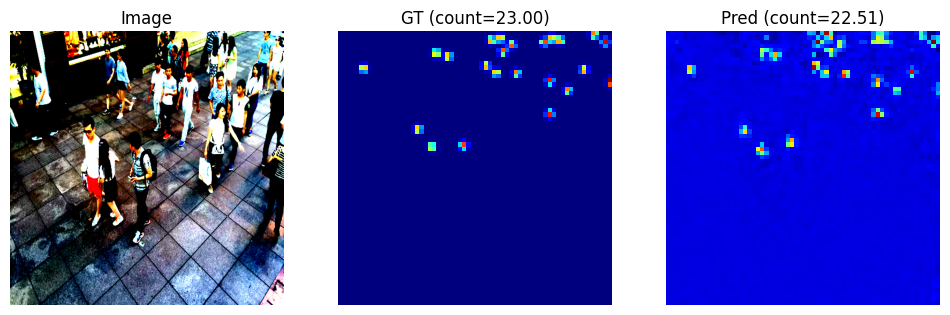

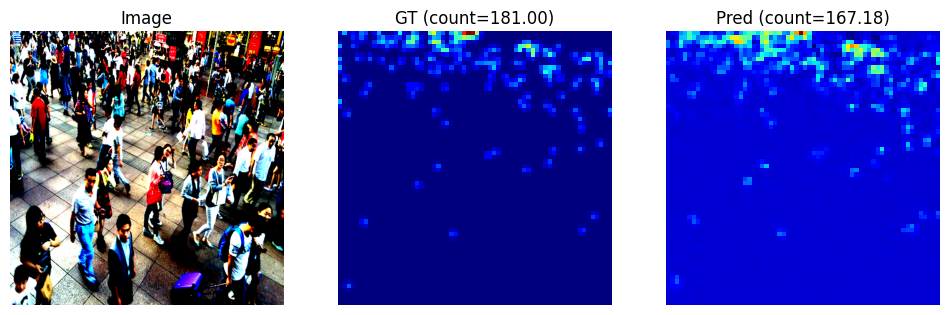

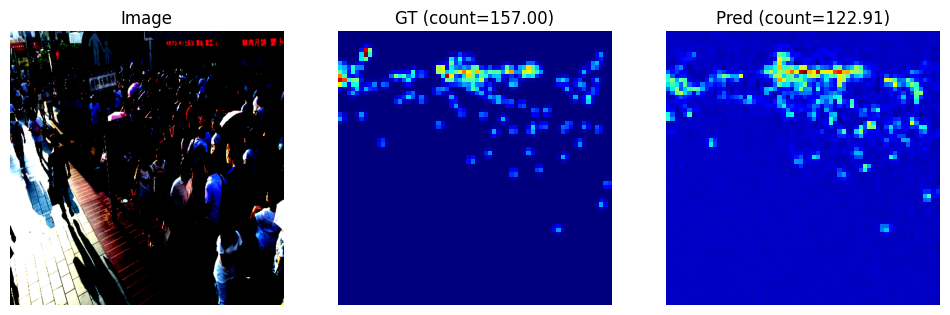

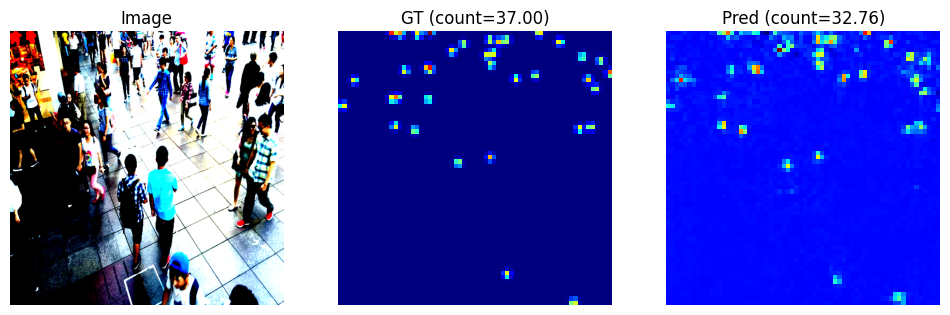

In [8]:
###############################################
# 8) VISUALIZE 4 SAMPLES
###############################################

def show_map(img, gt, pred):
    # Convert image tensor to numpy
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)

    # Convert GT & prediction to numpy
    gt_map = gt.squeeze().cpu().numpy()
    pr_map = pred.squeeze().cpu().numpy()

    # Plot
    plt.figure(figsize=(12,4))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    # GT density
    plt.subplot(1,3,2)
    plt.imshow(gt_map, cmap="jet")
    plt.axis("off")
    plt.title(f"GT (count={gt_map.sum():.2f})")

    # Predicted density
    plt.subplot(1,3,3)
    plt.imshow(pr_map, cmap="jet")
    plt.axis("off")
    plt.title(f"Pred (count={pr_map.sum():.2f})")

    plt.show()


# ---- RUN VISUALIZATION FOR 4 SAMPLES ----
for i in range(4):
    img, gt = test_ds[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).cuda())[0].cpu()
    show_map(img, gt, pred)
